## Timeseries of rainfall rates from E3SM vs CPOL

In [2]:
import warnings
warnings.filterwarnings("ignore")
import xarray
import pyart
import dask.bag as db
import cartopy.crs as ccrs

from dask_jobqueue import SLURMCluster
from glob import glob
from datetime import datetime
from cartopy import feature
%pylab inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119

Populating the interactive namespace from numpy and matplotlib


In [3]:
e3sm_path = '/lcrc/group/earthscience/cmdv/e3sm/*.nc'
ds_e3sm = xarray.open_mfdataset(e3sm_path)

In [4]:
ds_e3sm

<xarray.Dataset>
Dimensions:       (ilev: 73, lat: 129, lev: 72, lon: 256, nbnd: 2, slat: 128, slon: 256, time: 4129)
Coordinates:
  * lat           (lat) float64 -90.0 -88.59 -87.19 -85.78 -84.38 -82.97 ...
  * lon           (lon) float64 0.0 1.406 2.812 4.219 5.625 7.031 8.438 ...
  * slat          (slat) float64 -89.3 -87.89 -86.48 -85.08 -83.67 -82.27 ...
  * slon          (slon) float64 -0.7031 0.7031 2.109 3.516 4.922 6.328 ...
  * ilev          (ilev) float64 0.1 0.1477 0.218 0.3219 0.4753 0.7017 1.036 ...
  * lev           (lev) float64 0.1238 0.1828 0.2699 0.3986 0.5885 0.8689 ...
  * time          (time) datetime64[ns] 2009-12-01 2009-12-01T03:00:00 ...
Dimensions without coordinates: nbnd
Data variables:
    w_stag        (time, slat) float64 dask.array<shape=(4129, 128), chunksize=(240, 128)>
    lat_bnds      (time, lat, nbnd) float64 dask.array<shape=(4129, 129, 2), chunksize=(240, 129, 2)>
    lon_bnds      (time, lon, nbnd) float64 dask.array<shape=(4129, 256, 2), chunk

## Let's reduce the dataset a bit, shall we?

In [5]:
ds_e3sm.lat.values
bounding_box_1 = np.logical_and.reduce((ds_e3sm.PRECC.lat.values > -13.55,ds_e3sm.PRECC.lat.values < -10.94))
bounding_box_2 = np.logical_and.reduce((ds_e3sm.PRECC.lon.values > 129.7, ds_e3sm.PRECC.lon.values < 132.3))
rain_darwin = ds_e3sm.PRECL[:,bounding_box_1, bounding_box_2] + ds_e3sm.PRECC[:,bounding_box_1, bounding_box_2]
rain_darwin = rain_darwin*3600*1e3
lat_bnds = ds_e3sm.lat_bnds[0,bounding_box_1,:].values
lon_bnds = ds_e3sm.lon_bnds[0,bounding_box_2,:].values
mean_rain_darwin = rain_darwin.mean(axis=[1,2])
cloud_cover = ds_e3sm.CLDTOT[:,bounding_box_1, bounding_box_2]
cloud_cover_high = ds_e3sm.CLDHGH[:,bounding_box_1, bounding_box_2]
cloud_cover_low = ds_e3sm.CLDLOW[:,bounding_box_1, bounding_box_2]
cloud_cover_med = ds_e3sm.CLDMED[:,bounding_box_1, bounding_box_2]
print(rain_darwin)

<xarray.DataArray (time: 4129, lat: 2, lon: 2)>
dask.array<shape=(4129, 2, 2), dtype=float32, chunksize=(240, 2, 2)>
Coordinates:
  * lat      (lat) float64 -12.66 -11.25
  * lon      (lon) float64 130.8 132.2
  * time     (time) datetime64[ns] 2009-12-01 2009-12-01T03:00:00 ...


In [6]:
ds_e3sm.CLDTOT

<xarray.DataArray 'CLDTOT' (time: 4129, lat: 129, lon: 256)>
dask.array<shape=(4129, 129, 256), dtype=float32, chunksize=(240, 129, 256)>
Coordinates:
  * lat      (lat) float64 -90.0 -88.59 -87.19 -85.78 -84.38 -82.97 -81.56 ...
  * lon      (lon) float64 0.0 1.406 2.812 4.219 5.625 7.031 8.438 9.844 ...
  * time     (time) datetime64[ns] 2009-12-01 2009-12-01T03:00:00 ...
Attributes:
    units:          fraction
    long_name:      Vertically-integrated total cloud
    cell_methods:   time: mean
    basename:       CLDTOT
    cell_measures:  area: area

In [7]:
rain_darwin

<xarray.DataArray (time: 4129, lat: 2, lon: 2)>
dask.array<shape=(4129, 2, 2), dtype=float32, chunksize=(240, 2, 2)>
Coordinates:
  * lat      (lat) float64 -12.66 -11.25
  * lon      (lon) float64 130.8 132.2
  * time     (time) datetime64[ns] 2009-12-01 2009-12-01T03:00:00 ...

In [8]:
cpol_rate_path = '/lcrc/group/earthscience/radar/CPOL_level_1b/GRIDDED/GRID_150km_2500m/'
path_list = [glob(cpol_rate_path + '/**/*.nc', recursive=True)]
example_rad = pyart.io.read_grid(path_list[0][0])

# Do some optimization here by preloading lat/lon, and determining which fields to exclude
point_lat = example_rad.point_latitude['data'][0]
point_lon = example_rad.point_longitude['data'][0]
excluded_fields = list(example_rad.fields.keys())
excluded_fields.remove('radar_estimated_rain_rate')

In [9]:
example_rad.time['units']

'seconds since  2003-04-02T14:30:00Z'

In [18]:
def get_rainfall_rate_from_box(file_name, lat_bnds, lon_bnds, point_lat, point_lon, excluded_fields):
    radar = pyart.io.read_grid(file_name, excluded_fields=excluded_fields)
    rr = radar.fields['radar_estimated_rain_rate']['data'][1]
    rr = rr.filled(fill_value=0)
    x = radar.point_x["data"][1]
    y = radar.point_y["data"][1]
    
    out_rr = np.zeros((lat_bnds.shape[0], lon_bnds.shape[0]))
    print(out_rr.shape)
    for i in range(out_rr.shape[0]):
        for j in range(out_rr.shape[1]):
            bounding_box = np.logical_and.reduce((point_lat >= lat_bnds[i,0],
                                                 point_lat <= lat_bnds[i,1],
                                                 point_lon >= lon_bnds[j,0],
                                                 point_lon <= lon_bnds[j,1]))
            out_rr[i,j] = np.ma.mean(rr[bounding_box])
            print(('X range of box ' + str(j*2+i + 1) + ' ' + str(x[bounding_box].min()) + ' ' + str(x[bounding_box].max())))
            print(('Y range of box ' + str(j*2+i + 1) + ' ' + str(y[bounding_box].min()) + ' ' + str(y[bounding_box].max())))
    radtime = datetime.datetime.strptime(radar.time['units'], 'seconds since  %Y-%m-%dT%H:%M:%SZ')
    print(radtime)
    return out_rr, radtime

In [19]:
%time get_rainfall_rate_from_box(path_list[0][0], lat_bnds, lon_bnds, point_lat, point_lon, excluded_fields)

(2, 2)
X range of box 1 -105000.0 47500.0
Y range of box 1 -122500.0 32500.0
X range of box 3 50000.0 145000.0
Y range of box 3 -122500.0 32500.0
X range of box 2 -105000.0 47500.0
Y range of box 2 35000.0 145000.0
X range of box 4 50000.0 145000.0
Y range of box 4 35000.0 145000.0
2003-04-02 14:30:00
CPU times: user 247 ms, sys: 22.4 ms, total: 269 ms
Wall time: 269 ms


(array([[0., 0.],
        [0., 0.]]), datetime.datetime(2003, 4, 2, 14, 30))

In [ ]:
lat_bnds.values[1,0,0]

## Start our cluster

In [14]:
cluster = SLURMCluster(cores=36, project='rainfall', walltime='2:00:00', 
                       job_cpu=36, processes=18,
                       memory='128GB', local_dir='/lcrc/project/rainfall/dask_worker_space')

cluster.scale(18)         # Ask for ten workers

from dask.distributed import Client
client = Client(cluster)  # Connect this local process to remote workers

/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/tornado/concurrent.py:521: DeprecationWarning: @return_future is deprecated, use coroutines instead
  DeprecationWarning)


In [16]:
client

<Client: scheduler='tcp://140.221.70.5:44252' processes=18 cores=36>

In [ ]:
cluster.stop_all_jobs()

In [ ]:
print(len(path_list[0]))

In [ ]:
interval = int(len(path_list[0])/4)
the_bag1 = db.from_sequence(path_list[0][:interval], npartitions=288)
the_bag2 = db.from_sequence(path_list[0][interval:2*interval], npartitions=288)
the_bag3 = db.from_sequence(path_list[0][2*interval:3*interval], npartitions=288)
the_bag4 = db.from_sequence(path_list[0][3*interval:], npartitions=288)

In [ ]:
the_function = lambda file_name: get_rainfall_rate_from_box(
    file_name, lat_bnds, lon_bnds, point_lat, point_lon, excluded_fields)
%time out1 = the_bag1.map(the_function).compute()
print('Progress: 25%')
%time out2 = the_bag2.map(the_function).compute()
print('Progress: 25%')
%time out3 = the_bag3.map(the_function).compute()
print('Progress: 25%')
%time out4 = the_bag4.map(the_function).compute()
print('Progress: 25%')

In [ ]:
rr1 = np.stack([x[0] for x in out1])
time1 = np.stack([x[1] for x in out1])
rr2 = np.stack([x[0] for x in out2])
time2 = np.stack([x[1] for x in out2])
rr3 = np.stack([x[0] for x in out3])
time3 = np.stack([x[1] for x in out3])
rr4 = np.stack([x[0] for x in out4])
time4 = np.stack([x[1] for x in out4])

In [ ]:
rain_rate_cpol = np.concatenate([rr1, rr2, rr3, rr4])
time_cpol = list(np.concatenate([time1, time2, time3, time4]))

out_ds = xarray.Dataset({'rain_rate': (['time', 'x', 'y'], rain_rate_cpol)},
                        coords={'time': time_cpol, 'x': np.mean(lat_bnds, axis=1),
                                'y': np.mean(lon_bnds, axis=1)})
out_ds = out_ds.sortby('time')
out_ds.to_netcdf('CPOL_rainrates_all_data.nc')
out_ds

In [9]:
out_ds = xarray.open_dataset('CPOL_rainrates_all_data.nc')

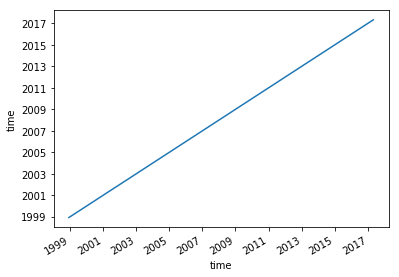

In [10]:
out_ds.time.plot()

In [11]:
domain_mean_rr = out_ds.rain_rate.mean(axis=1)
domain_mean_rr = domain_mean_rr.mean(axis=1)

e3sm_mean_rainfall = mean_rain_darwin*3
domain_mean_rr = domain_mean_rr.resample(time='3H').sum()/6
out_ds_averaged = out_ds.resample(time='3H').sum()/6
e3sm_mean_rainfall_4 = rain_darwin*3

In [12]:
print(out_ds_averaged)

<xarray.Dataset>
Dimensions:    (time: 53775, x: 2, y: 2)
Coordinates:
  * y          (y) float64 130.8 132.2
  * time       (time) datetime64[ns] 1998-12-06T06:00:00 1998-12-06T09:00:00 ...
  * x          (x) float64 -12.66 -11.25
Data variables:
    rain_rate  (time, x, y) float64 0.5565 0.3709 3.111 0.7286 0.3422 ...


Text(0.5,1,'2010-2011')

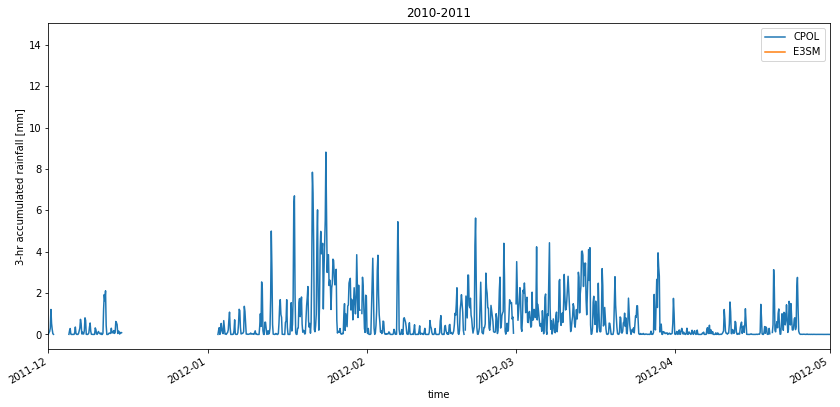

In [17]:
plt.figure(figsize=(14, 6))
domain_mean_rr.plot(label='CPOL')
e3sm_mean_rainfall.plot(label='E3SM')
plt.legend()
plt.xlim([datetime.datetime(2011, 12, 1), datetime.datetime(2012, 5, 1)])
plt.ylabel('3-hr accumulated rainfall [mm]')
plt.title('2010-2011')

In [20]:
def dt64_to_dt(dt):
    ts = (dt - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
    return datetime.datetime.utcfromtimestamp(ts)

hours_e3sm = np.array([dt64_to_dt(x).hour for x in e3sm_mean_rainfall.time.values])
hours_cpol = np.array([dt64_to_dt(x).hour for x in domain_mean_rr.time.values])
minute_e3sm = np.array([dt64_to_dt(x).minute for x in e3sm_mean_rainfall.time.values])
minute_cpol = np.array([dt64_to_dt(x).minute for x in domain_mean_rr.time.values])

# Convert to local time [UTC+9.5]
hours_e3sm = hours_e3sm + 9.5 + minute_e3sm/60
hours_e3sm[hours_e3sm >= 24] = hours_e3sm[hours_e3sm >= 24] - 24
hours_cpol = hours_cpol + 9.5 + minute_cpol/60
hours_cpol[hours_cpol >= 24] = hours_cpol[hours_cpol >= 24] - 24
hour_bins = np.arange(0, 25, 3)
rainfall_bins = np.logspace(-1, 1, 12.5)
cpol_diurnal_cycle_hist = np.zeros((len(hour_bins)-1, len(rainfall_bins)-1))
e3sm_diurnal_cycle_hist = np.zeros((len(hour_bins)-1, len(rainfall_bins)-1))

rr_e3sm = rain_darwin.values[:,0,1]
rr_cpol = out_ds_averaged.rain_rate.values[:,0,1]

for i in range(len(hour_bins)-1):
    inds = np.where(np.logical_and(hours_e3sm >= hour_bins[i], hours_e3sm < hour_bins[i+1]))[0]
    hist, bins = np.histogram(rr_e3sm[inds], bins=rainfall_bins)
    e3sm_diurnal_cycle_hist[i] = hist
    inds = np.where(np.logical_and(hours_cpol >= hour_bins[i], hours_cpol < hour_bins[i+1]))[0]
    hist, bins = np.histogram(rr_cpol[inds], bins=rainfall_bins)
    cpol_diurnal_cycle_hist[i] = hist

/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware da

/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware da

/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware da

/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware da

/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware da

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anacond

/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware da

/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware da

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anacond

/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware da

/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware da

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Text(0.5,1,'CPOL (Box 2)')

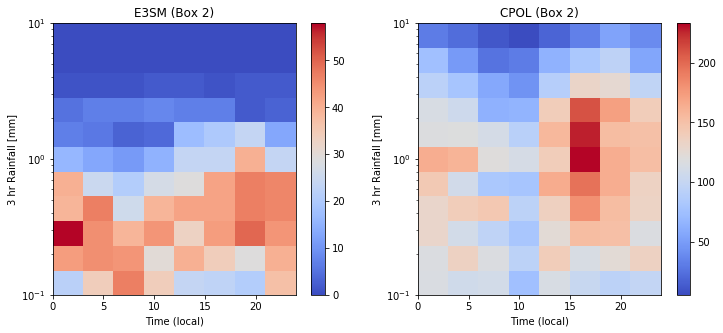

In [24]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
x, y = np.meshgrid(hour_bins, rainfall_bins)
mesh = ax[0].pcolormesh(x, y, e3sm_diurnal_cycle_hist.T, cmap='coolwarm')
plt.colorbar(mesh, ax =ax[0])
ax[0].set_yscale('log')
ax[0].set_ylabel('3 hr Rainfall [mm]')
ax[0].set_xlabel('Time (local)')
ax[0].set_title('E3SM (Box 2)')

mesh = ax[1].pcolormesh(x, y, cpol_diurnal_cycle_hist.T, cmap='coolwarm')
plt.colorbar(mesh, ax=ax[1])
ax[1].set_yscale('log')
ax[1].set_xlabel('Time (local)')
ax[1].set_ylabel('3 hr Rainfall [mm]')
ax[1].set_title('CPOL (Box 2)')

In [ ]:
out_ds_averaged

In [ ]:
print(out_ds_averaged.x.values[0])

In [ ]:
ax = plt.axes(projection=ccrs.PlateCarree())
plt.text(out_ds_averaged.y.values[0]-0.15, out_ds_averaged.x.values[0]-0.15, '1', fontsize=26, fontweight='bold')
plt.text(out_ds_averaged.y.values[0]-0.15, out_ds_averaged.x.values[1]-0.15, '2', fontsize=26, fontweight='bold')
plt.text(out_ds_averaged.y.values[1]-0.15, out_ds_averaged.x.values[0]-0.15, '3', fontsize=26, fontweight='bold')
plt.text(out_ds_averaged.y.values[1]-0.15, out_ds_averaged.x.values[1]-0.15, '4', fontsize=26, fontweight='bold')
plt.gca().add_patch(
                plt.Rectangle((lon_bnds[0,0], lat_bnds[0,0]),
                              lon_bnds[0,1] - lon_bnds[0,0],
                              lat_bnds[0,1] - lat_bnds[0,0], fill=True, alpha=0.5,
                              edgecolor='k', color='k', linewidth=1)
                )
plt.gca().add_patch(
                plt.Rectangle((lon_bnds[0,0], lat_bnds[0,1]),
                              lon_bnds[0,1] - lon_bnds[0,0],
                              lat_bnds[1,1] - lat_bnds[0,1], fill=True, alpha=0.5,
                              edgecolor='k', color='b', linewidth=1)
                )
plt.gca().add_patch(
                plt.Rectangle((lon_bnds[1,0], lat_bnds[1,0]),
                              lon_bnds[1,1] - lon_bnds[1,0],
                              lat_bnds[1,1] - lat_bnds[1,0], fill=True, alpha=0.5,
                              edgecolor='k', color='r', linewidth=1)
                )
plt.gca().add_patch(
                plt.Rectangle((lon_bnds[1,0], lat_bnds[0,0]),
                              lon_bnds[1,1] - lon_bnds[1,0],
                              lat_bnds[1,1] - lat_bnds[1,0], fill=True, alpha=0.5,
                              edgecolor='k', color='g', linewidth=1)
                )
ax.set_extent([129.5, 133.5, -14, -10])
ax.coastlines(resolution='10m')
#ax.add_feature(feature.LAND)
#ax.add_feature(feature.OCEAN)
ax.set_xticks([129, 130, 131, 132, 133])
ax.set_xlabel('Longitude [$\degree$]')
ax.set_ylabel('Latitiude [$\degree$]')
ax.set_yticks([-14, -13,- 12, -11, -10])
ax.gridlines()

In [ ]:
bounding_box_1 = np.logical_and.reduce((ds_e3sm.PRECC.lat.values > -13.55,ds_e3sm.PRECC.lat.values < -10.94))
bounding_box_2 = np.logical_and.reduce((ds_e3sm.PRECC.lon.values > 129.7, ds_e3sm.PRECC.lon.values < 132.3))
U_darwin = ds_e3sm.U[:,:,bounding_box_1, bounding_box_2] 
V_darwin = ds_e3sm.V[:,:,bounding_box_1, bounding_box_2]


## Large scale forcing

In [25]:
dros_forcing = '/home/rjackson/data/Drosdowsky.cdf'
dros_ds = xarray.open_dataset(dros_forcing)
dros_ds

<xarray.Dataset>
Dimensions:  (time: 1819)
Dimensions without coordinates: time
Data variables:
    groups   (time) int32 ...
    year     (time) float64 ...
    month    (time) float64 ...
    day      (time) float64 ...
    cape     (time) float64 ...
    shear    (time) float64 ...
    rh500    (time) float64 ...

In [ ]:
year_cpol = np.array([dt64_to_dt(x).year for x in domain_mean_rr.time.values])
month_cpol = np.array([dt64_to_dt(x).month for x in domain_mean_rr.time.values])
day_cpol = np.array([dt64_to_dt(x).day for x in domain_mean_rr.time.values])
year_dros = dros_ds.year.values
month_dros = dros_ds.month.values
day_dros = dros_ds.day.values

class_cpol = np.nan*np.ones(len(year_cpol))
for i in range(len(class_cpol)):
    the_index = np.where(np.logical_and.reduce((year_dros == year_cpol[i], 
                                                month_dros == month_cpol[i],
                                                day_dros == day_cpol[i])))[0]
    if(len(the_index) > 0):
        class_cpol[i] = dros_ds.groups.values[the_index]


In [27]:
bounding_box_1 = np.logical_and.reduce((ds_e3sm.PRECC.lat.values > -13.55,ds_e3sm.PRECC.lat.values < -10.94))
bounding_box_2 = np.logical_and.reduce((ds_e3sm.PRECC.lon.values > 129.7, ds_e3sm.PRECC.lon.values < 132.3))
U_e3sm = ds_e3sm.U[:,:,bounding_box_1, bounding_box_2].mean(axis=[2,3])
U_e3sm
U_e3sm.load()

<xarray.DataArray 'U' (time: 4129, lev: 72)>
array([[  6.659653,  -3.174256, -13.127542, ...,  -1.012613,  -0.754446,
         -0.413732],
       [  5.205791,  -1.959698,  -8.274486, ...,  -1.120577,  -0.937686,
         -0.648329],
       [ -3.69234 ,  -9.941418,  -9.243726, ...,  -1.121889,  -0.946744,
         -0.67933 ],
       ...,
       [ 14.970815,  24.998367,  34.39917 , ...,  -6.751969,  -5.486011,
         -3.68384 ],
       [ 16.901476,  26.726795,  35.894638, ...,  -6.673649,  -5.324526,
         -3.565127],
       [ 18.672247,  28.21759 ,  36.09556 , ...,  -6.428785,  -5.252678,
         -3.78795 ]], dtype=float32)
Coordinates:
  * lev      (lev) float64 0.1238 0.1828 0.2699 0.3986 0.5885 0.8689 1.283 ...
  * time     (time) datetime64[ns] 2009-12-01 2009-12-01T03:00:00 ...

In [28]:
pres_levels = U_e3sm.lev
surface_to_500 = np.where(pres_levels > 500)[0]
upper = np.where(np.logical_and(pres_levels > 100, pres_levels < 300))[0]
DLM = np.zeros(len(U_e3sm.time.values))
U300100 = np.zeros(len(U_e3sm.time.values))
classification_Drosdowsky = np.zeros(len(U_e3sm.time.values))
for i in range(0,len(U_e3sm.time.values)):
    DLM[i] = sum(pres_levels[surface_to_500]*U_e3sm[i,surface_to_500]/(sum(pres_levels[surface_to_500])))
    U300100[i] = np.mean(U_e3sm[i,upper])
    
N = 1
break_spell = 0
U = 2.5
# Calculate Deep Layer Mean wind and classify time periods
j = 0
for i in range(0,len(DLM)-1):
    if(np.mean(DLM[i-N:i]) > U*(N+1)/N and DLM[i] > 0):
        if(U300100[i] < 0):
            N = N + 1
        else:
            if(N > 1):
                classification_Drosdowsky[j-N+1:j-1] = 1
                N = 1
    else:
        if(N > 1):
            classification_Drosdowsky[j-N+1:j-1] = 1
            N = 1
    j = j + 1

In [ ]:
hours_e3sm = np.array([dt64_to_dt(x).hour for x in e3sm_mean_rainfall.time.values])
hours_cpol = np.array([dt64_to_dt(x).hour for x in domain_mean_rr.time.values])
minute_e3sm = np.array([dt64_to_dt(x).minute for x in e3sm_mean_rainfall.time.values])
minute_cpol = np.array([dt64_to_dt(x).minute for x in domain_mean_rr.time.values])

# Convert to local time [UTC+9.5]
hours_e3sm = hours_e3sm + 9.5 + minute_e3sm/60
hours_e3sm[hours_e3sm >= 24] = hours_e3sm[hours_e3sm >= 24] - 24
hours_cpol = hours_cpol + 9.5 + minute_cpol/60
hours_cpol[hours_cpol >= 24] = hours_cpol[hours_cpol >= 24] - 24
hour_bins = np.arange(0, 25, 3)
rainfall_bins = np.logspace(-1, 1, 12)
cpol_diurnal_cycle_hist = np.zeros((len(hour_bins)-1, len(rainfall_bins)-1))
e3sm_diurnal_cycle_hist = np.zeros((len(hour_bins)-1, len(rainfall_bins)-1))

rr_e3sm = rain_darwin.values[:,0,0]
rr_cpol = out_ds_averaged.rain_rate.values[:,0,0]

dros = 1
for i in range(len(hour_bins)-1):
    inds = np.where(np.logical_and.reduce((
        classification_Drosdowsky == dros, hours_e3sm >= hour_bins[i], hours_e3sm < hour_bins[i+1])))[0]
    hist, bins = np.histogram(rr_e3sm[inds], bins=rainfall_bins)
    e3sm_diurnal_cycle_hist[i] = hist
    inds = np.where(np.logical_and.reduce(
        (class_cpol == dros, hours_cpol >= hour_bins[i], hours_cpol < hour_bins[i+1])))[0]
    hist, bins = np.histogram(rr_cpol[inds], bins=rainfall_bins)
    cpol_diurnal_cycle_hist[i] = hist

Text(0.5,1,'CPOL Monsoon Box 1')

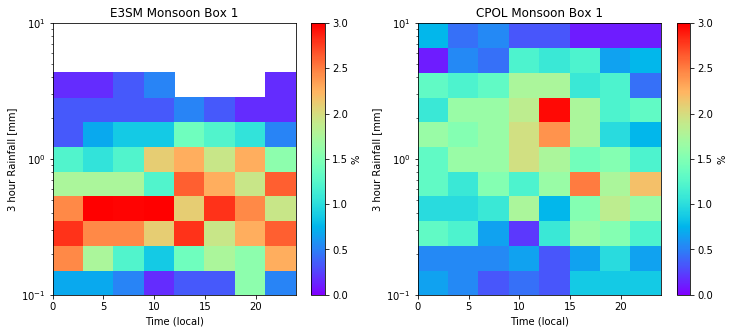

In [68]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
x, y = np.meshgrid(hour_bins, rainfall_bins)
e3sm_diurnal_cycle_hist = np.ma.masked_where(e3sm_diurnal_cycle_hist == 0, e3sm_diurnal_cycle_hist)
cpol_diurnal_cycle_hist = np.ma.masked_where(cpol_diurnal_cycle_hist == 0, cpol_diurnal_cycle_hist)
mesh = ax[0].pcolormesh(x, y, e3sm_diurnal_cycle_hist.T/np.sum(e3sm_diurnal_cycle_hist)*100, vmin=0, vmax=3,
                       cmap='rainbow')
bar = plt.colorbar(mesh, ax =ax[0])
bar.set_label('%')
ax[0].set_yscale('log')
ax[0].set_ylabel('3 hour Rainfall [mm]')
ax[0].set_xlabel('Time (local)')
ax[0].set_title('E3SM Monsoon Box 1')

mesh = ax[1].pcolormesh(x, y, cpol_diurnal_cycle_hist.T/np.sum(cpol_diurnal_cycle_hist)*100, vmin=0, vmax=3,
                        cmap='rainbow')
bar = plt.colorbar(mesh, ax =ax[1])
bar.set_label('%')
ax[1].set_yscale('log')
ax[1].set_xlabel('Time (local)')
ax[1].set_ylabel('3 hour Rainfall [mm]')
ax[1].set_title('CPOL Monsoon Box 1')

In [ ]:
print(e3sm_diurnal_cycle_hist)

In [ ]:
hours_e3sm = np.array([dt64_to_dt(x).hour for x in e3sm_mean_rainfall.time.values])
minute_e3sm = np.array([dt64_to_dt(x).minute for x in e3sm_mean_rainfall.time.values])

# Convert to local time [UTC+9.5]
hours_e3sm = hours_e3sm + 9.5 + minute_e3sm/60
hours_e3sm[hours_e3sm >= 24] = hours_e3sm[hours_e3sm >= 24] - 24
hour_bins = np.arange(0, 25, 3)
cloudcover_bins = np.linspace(0, 100, 10)
e3sm_diurnal_cycle_hist_break = np.zeros((len(hour_bins)-1, len(cloudcover_bins)-1))
e3sm_diurnal_cycle_hist_monsoon = np.zeros((len(hour_bins)-1, len(cloudcover_bins)-1))

rr_e3sm = cloud_cover_low.values[:,0,0]*100

dros = 0
for i in range(len(hour_bins)-1):
    inds = np.where(np.logical_and.reduce((
        classification_Drosdowsky == 0, hours_e3sm >= hour_bins[i], hours_e3sm < hour_bins[i+1])))[0]
    hist, bins = np.histogram(rr_e3sm[inds], bins=cloudcover_bins)
    e3sm_diurnal_cycle_hist_break[i] = hist
    inds = np.where(np.logical_and.reduce((
        classification_Drosdowsky == 1, hours_e3sm >= hour_bins[i], hours_e3sm < hour_bins[i+1])))[0]
    hist, bins = np.histogram(rr_e3sm[inds], bins=cloudcover_bins)
    e3sm_diurnal_cycle_hist_monsoon[i] = hist

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
x, y = np.meshgrid(hour_bins, cloudcover_bins)
mesh = ax[0].pcolormesh(x, y, e3sm_diurnal_cycle_hist_break.T)
plt.colorbar(mesh, ax=ax[0])
ax[0].set_ylabel('Low cloud cover [%]')
ax[0].set_xlabel('Time (local)')
ax[0].set_title('E3SM (Box 1) Break')

x, y = np.meshgrid(hour_bins, cloudcover_bins)
mesh = ax[1].pcolormesh(x, y, e3sm_diurnal_cycle_hist_monsoon.T)
plt.colorbar(mesh, ax=ax[1])
ax[1].set_ylabel('Low cloud cover [%]')
ax[1].set_xlabel('Time (local)')
ax[1].set_title('E3SM (Box 1) Monsoon')

In [ ]:
print(cloudcover_bins)

(130, 140)

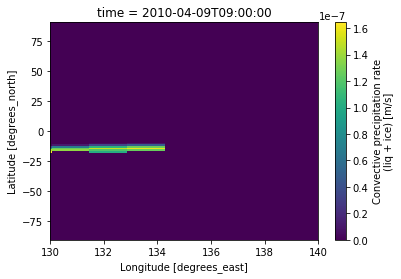

In [41]:
ds_e3sm.PRECC.isel(time=1035).plot()
